In [115]:
# NVIDIA GPU 모니터링 위하여 NVIDIA System Management Interface 명령어
!nvidia-smi

Fri Apr 19 16:50:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              29W /  70W |    279MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [116]:
import os
import torch
# torch.nn for neural network
import torch.nn as nn
# torch.optim for optimization algorithms
import torch.optim as optim
# torchvision.datasets for downloading datasets
import torchvision.datasets as datasets
# torchvision.transforms for data transformation
import torchvision.transforms as transforms

# This mounts your google drive storage to this code
# 데이터셋과 모델을 저장하기 위한 용도
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [117]:
# device 변수에 CUDA가 사용가능하다면 cuda를, 아니면 cpu를 할당함
device = "cuda" if torch.cuda.is_available() else "cpu"
# 현재 사용 중인 device 출력
print(f"Using {device} device")

# root에 google drive 디렉토리를 지정
root = '/content/gdrive/My Drive/Test/'

# root = './'
# if not os.path.exists(root):
#     os.makedirs(root)

Using cuda device


In [118]:
# settings for data normalization

# dataset의 FashionMNIST를 train data에 저장
train_data = datasets.FashionMNIST(
    # 데이터셋 저장할 디렉토리 경로
    root=root,
    # train = True로 설정하여 train data를 저장
    train=True,
    download=True,
    # 데이터를 tensor로 변환
    transform=transforms.ToTensor(),
)

# dataset의 FashionMNIST를 test data에 저장
test_data = datasets.FashionMNIST(
    # 데이터셋 저장할 디렉토리 경로
    root=root,
    # train = False로 설정하여 test data를 저장
    train=False,
    download=True,
    # 데이터를 tensor로 변환
    transform=transforms.ToTensor(),
)

# data lenth 출력
print("train_data lenth :", len(train_data))
print("test_data lenth\t :", len(test_data))

# data shape 출력
print("train_data shpae :", train_data[0][0].shape)
print("test_data shpae\t :", test_data[0][0].shape)


batch_size = 50
# train_data의 data를 batch_size만큼 random하게(shuffle=True) 추출하는 train_loader
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
# test_data의 data를 batch_size만큼 random하게(shuffle=True) 추출하는 test_loader
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)


train_data lenth : 60000
test_data lenth	 : 10000
train_data shpae : torch.Size([1, 28, 28])
test_data shpae	 : torch.Size([1, 28, 28])


In [119]:
# define the CNN:
# two convolution layers followed by two linear layers

# nn.Module을 상속받아 neural network class를 정의
class MyConvNet(nn.Module):
    # define layers: two conv layers and two linear (fully connected) layers
    # MyConvNet 클래스의 초기화, 신경망의 구조 정의
    # 3개의 convolution layer, 2개의 fully connected layer로 구성
    def __init__(self):
        # 부모 클래스의 __init__ 메소드를 사용하기 위한 super 함수
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv layer 1
            nn.Conv2d(1, 32, 5),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            # conv layer 2
            nn.Conv2d(32, 64, 5),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            # conv layer 3
            nn.Conv2d(64, 128, 3),
            nn.ELU(),

            nn.Flatten(),

            # fully connected layer
            nn.Linear(2 * 2 * 128, 256),
            nn.ELU(),
            # 출력 class의 개수에 맞춰 ouput 설정
            nn.Linear(256, 10)
        )

    # network connection: two conv layers, each followed by relu and max-pooling with (2x2) kernel, and two linear layer
    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)


# generate neural net model
model = MyConvNet().to(device)
print(model)


MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ELU(alpha=1.0)
    (11): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [120]:
# optimizer 알고리즘으로 AdamW를 사용, learning rate = 0.001
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# loss function으로 CrossEntropyLoss를 사용
criterion = nn.CrossEntropyLoss()

In [121]:
# training and test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    # model.train()
    current_loss= 0.0
    # batch 번호, 입력 data x, target data target을 train_loader에서 가져옴
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        # cnn 모델에 input data x를 넣어 out을 계산
        out = model(x)
        # cross entropy loss를 활요하여 loss 계산
        loss = criterion(out,target)

        # optimizer의 gradient 0으로 초기화
        optimizer.zero_grad()
        # 위에서 계산한 loss를 backpropagation
        loss.backward()
        # optimizer를 사용하여 가중치 업데이트
        optimizer.step()
        current_loss += loss

        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0


    # test phase
    with torch.no_grad():
        # model.eval()
        total_samples = 0.0
        correct_samples = 0.0
        # test_loader에서 x, target을 가져와서 test 수행
        for (x, target) in test_loader:
            x, target = x.to(device), target.to(device)
            # test data를 model에 넣어 out 계산한 뒤, 가장 높은 확률을 가진 class 선택
            out = model(x)
            pred = torch.argmax(out,1)
            # test data에서 올바르게 예측한 data의 수를 correct_samples에 더함
            correct_samples += (pred == target).sum()
        # accuracy 출력
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))




epoch: 0, batch_num: 100, current_loss: 0.926
epoch: 0, batch_num: 200, current_loss: 0.596
epoch: 0, batch_num: 300, current_loss: 0.522
epoch: 0, batch_num: 400, current_loss: 0.485
epoch: 0, batch_num: 500, current_loss: 0.450
epoch: 0, batch_num: 600, current_loss: 0.437
epoch: 0, batch_num: 700, current_loss: 0.404
epoch: 0, batch_num: 800, current_loss: 0.393
epoch: 0, batch_num: 900, current_loss: 0.366
epoch: 0, batch_num: 1000, current_loss: 0.350
epoch: 0, batch_num: 1100, current_loss: 0.383
epoch: 0, batch_num: 1200, current_loss: 0.357
Accuracy: 85.950
epoch: 1, batch_num: 100, current_loss: 0.314
epoch: 1, batch_num: 200, current_loss: 0.323
epoch: 1, batch_num: 300, current_loss: 0.314
epoch: 1, batch_num: 400, current_loss: 0.322
epoch: 1, batch_num: 500, current_loss: 0.324
epoch: 1, batch_num: 600, current_loss: 0.330
epoch: 1, batch_num: 700, current_loss: 0.310
epoch: 1, batch_num: 800, current_loss: 0.307
epoch: 1, batch_num: 900, current_loss: 0.303
epoch: 1, batc

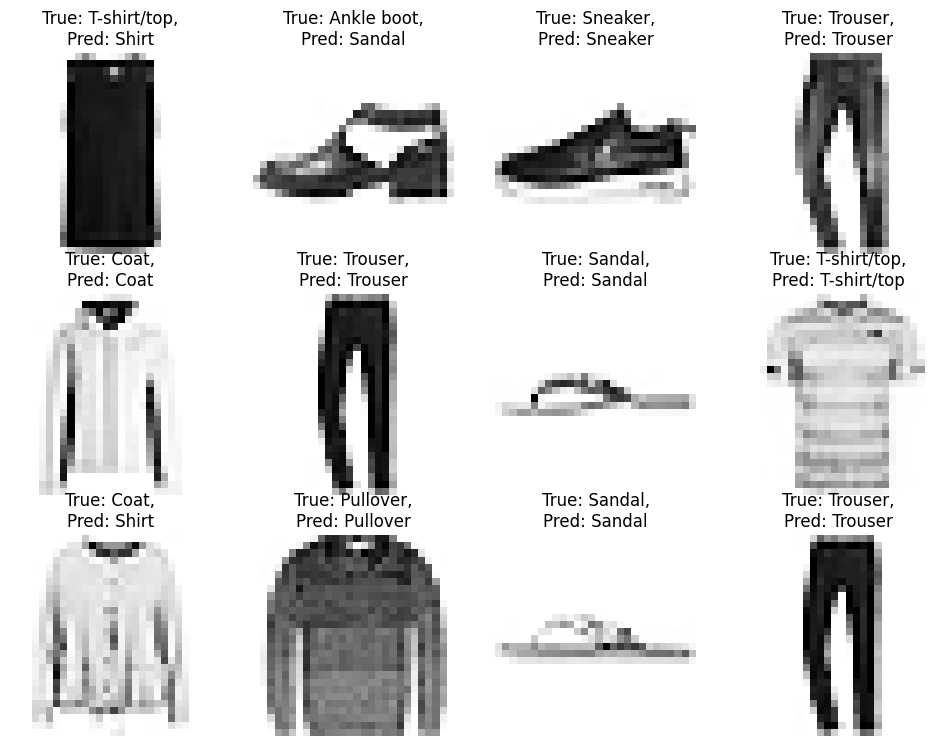

In [122]:
# Display Some test results
import numpy as np
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# take one batch of the data
test_data, test_labels = next(iter(test_loader))

# if cuda_available:
test_data, test_labels = test_data.to(device), test_labels.to(device)
out = model(test_data)              # put the test data to the trained network
pred = torch.argmax(out,1)          # prediction to the highest probability


sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size

random_samples = test_data[sample_index].cpu().numpy()

plt.figure(figsize=(12, 12))

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    plt.imshow(random_samples[k].reshape(28, 28),cmap='Greys')
    plt.title("True: " + str( classes[test_labels[sample_index[k]].item()]) + ",\nPred: " + str(classes[pred[sample_index[k]].item()]))
    plt.axis('off')


plt.show()

In [ ]:
# save model
torch.save(model, root + 'my_CNN_model.pth')

# load model
# model = torch.load('my_CNN_model.pth')

In [ ]:
# # save model weights
# torch.save(model.state_dict(), 'model_weights.pth')

# # load model weights
# model = MyConvNet()
# model.load_state_dict(torch.load('model_weights.pth'))
